# GAN

## importing libraries

In [1]:
import torch
import time
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import dltools

## importing data & creating helper functions

In [2]:
def mnist_data():
    
    compose = transforms.Compose([transforms.ToTensor()])
    outdir = "./datasets"
    return datasets.MNIST(root= outdir, transform= compose, download= True)

In [3]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [4]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = torch.randn(size, 100)
    return n

In [5]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1)
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1)
    return data

## creating a Discriminator & Generator

In [6]:
class Discriminator(nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(Discriminator, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [7]:
class Generator(nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(Generator, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

## Train time routines & params

In [8]:
discriminator = Discriminator()
generator = Generator()

num_epochs = 300

criterion = nn.BCELoss()

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)


In [9]:
def train_generator(optimizer, static_noise):
    
    optimizer.zero_grad()
    
    N = static_noise.size()[0]
    
    labels = ones_target(N)
    
    preds = discriminator(fake_data)
        
    gloss = criterion(preds, labels)
    
    gloss.backward()
    
    optimizer.step()
    
    return gloss.item()

In [10]:
def train_discriminator(optimizer, real_data, fake_data):
    
    optimizer.zero_grad()
    
    N = real_data.size(0)
    M = fake_data.size(0)
    
    real_preds = discriminator(real_data)
    fake_preds = discriminator(fake_data)
    
    labels = ones_target(N)
    real_loss = criterion(real_preds, labels)
    labels = zeros_target(M)
    fake_loss = criterion(fake_preds, labels)
    
    dloss = real_loss + fake_loss
    
    dloss.backward(retain_graph=True)
    
    optimizer.step()
    
    return dloss.item()

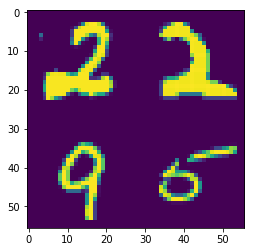

In [11]:
static_noise = noise(256)
data = mnist_data()
data_loader = DataLoader(data, batch_size=256, shuffle=True)

iterator = iter(data_loader)
sample = iterator.next()

img = dltools.make_image_grid(sample, 2, 2)
plt.imshow(img)

## Training

In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

<IPython.core.display.Javascript object>


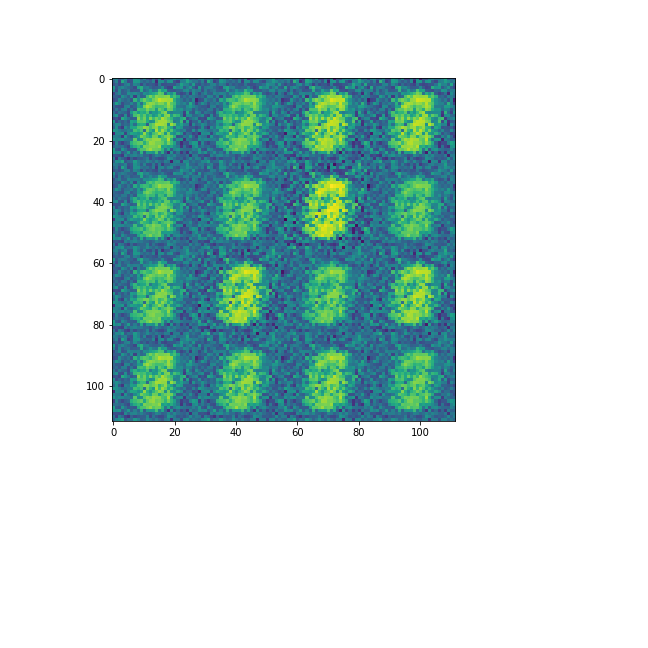

epoch : 0
completed : 0.0
-----discriminator loss : 1.382882833480835 	 generator loss : 0.6906480193138123
epoch : 0
completed : 10.202231520223153
-----discriminator loss : 0.5658111572265625 	 generator loss : 2.287069082260132
epoch : 0
completed : 20.146443514644353
-----discriminator loss : 1.3469765186309814 	 generator loss : 0.9142398238182068
epoch : 0
completed : 30.14644351464435
-----discriminator loss : 1.4194446802139282 	 generator loss : 0.47889620065689087
epoch : 0
completed : 40.0139470013947
-----discriminator loss : 1.3439127206802368 	 generator loss : 0.7146787047386169
epoch : 0
completed : 50.08716875871687
-----discriminator loss : 1.1655163764953613 	 generator loss : 1.5307644605636597
epoch : 0
completed : 60.638075313807526
-----discriminator loss : 1.6076290607452393 	 generator loss : 0.6180515289306641
epoch : 0
completed : 70.0836820083682
-----discriminator loss : 1.4031153917312622 	 generator loss : 0.7132842540740967


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


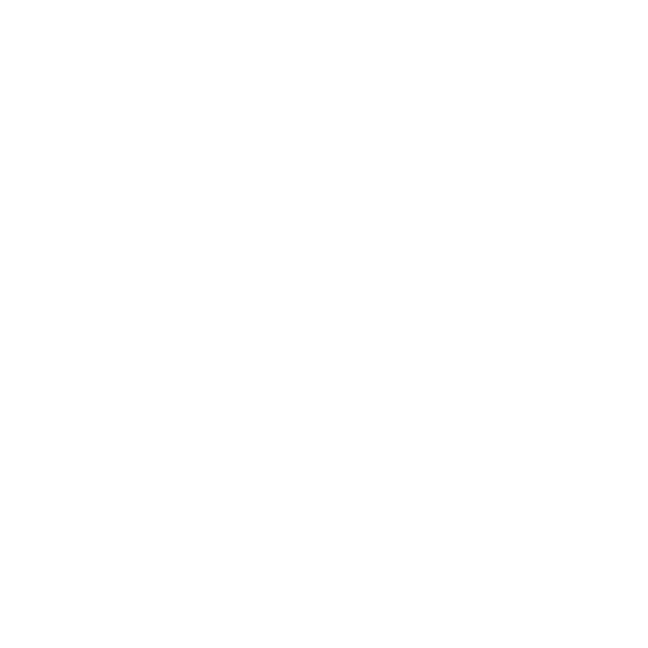

In [13]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
plt.ion()
plt.gcf().subplots_adjust(bottom=0.35)
plt.gcf().subplots_adjust(right=0.75)

fig.show()
fig.canvas.draw()

for i in range(num_epochs):
    
    batch_porgress = 0
    printed = 0
    
    for inx, data in enumerate(data_loader):
        
        real_data, _ = data
        real_data = real_data.view(-1,28*28)
        
        #1. Train Discriminator
        fake_data = generator(static_noise)
        Dloss = train_discriminator(d_optimizer,real_data,fake_data)
        
        #2. Train Generator
        Gloss = train_generator(g_optimizer, fake_data)
        
        batch_porgress += inx
        completed = (batch_porgress/28680) *100
        
        with torch.no_grad():
            fake_data = generator(static_noise)
            fake_data = vectors_to_images(fake_data)
      
        
        ax.clear()
        
        img = dltools.make_image_grid([fake_data], 4, 4)
        ax.imshow(img)
        
        fig.canvas.draw()   # draw
        time.sleep(0.5)
        
        if int(completed)%10 == 0 and printed!=1 :
            print(f"epoch : {i}")
            print(f"completed : {completed}")
            print(f"-----discriminator loss : {Dloss} \t generator loss : {Gloss}")
            printed=1
            
        if  int(completed)%10 != 0 :
            printed = 0
      
    print("===========================================================================================")